In [1]:
import pyvisa as pv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def FindInstrument():
    instrument_name = list(filter(lambda x: 'USB0::0x1AB1::0x04CE::DS1ZD212100403::INSTR' in x,
                                  all_instruments))  # USB0::0x1AB1::0x04CE::DS1ZD212100403::INSTR адрес прибора. Если используете другой прибор, то посмотрите вывод строки print(all_instruments)
    if len(instrument_name) == 0:
        print('Осциллограф не найден в списке устройств')
    else:
        return instrument_name[0]

rm = pv.ResourceManager()  # вызывает менеджер работы
all_instruments = rm.list_resources()  # показывает доступные порты передачи данных,имя которых по дефолту заканчивается на ::INSTR. USB RAW и TCPIP SOCKET не выводятся, но чтобы их посмотерть: '?*' в аргумент list_resources()
print('all resources', all_instruments)
print(FindInstrument())  # вызываю функцию для теста подключения. Должна вернуть адрес USB
rigol = rm.open_resource(FindInstrument())

all resources ('USB0::0x1AB1::0x04CE::DS1ZD212100403::INSTR',)
USB0::0x1AB1::0x04CE::DS1ZD212100403::INSTR


In [ ]:
rigol.write(':ACQ:MDEP 24000000')

<class 'numpy.ndarray'>
[ 35  57  48 ... 126 125  10]


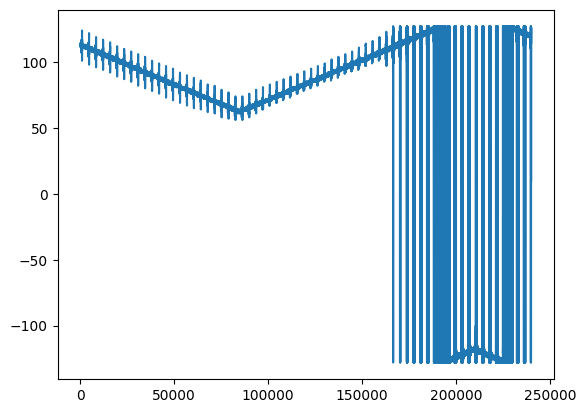

In [142]:
rigol.write(':WAV:SOUR CHAN1')
rigol.write(':WAV:MODE RAW')
rigol.write('"WAV:FORM BYTE')
rigol.write(':STOP')
rigol.write(':WAV:STAR 1')
rigol.write(':WAV:STOP 240000')
rigol.write(':WAV:DATA?')
rawdata1 = rigol.read_raw()
rigol.write(':RUN')
data = np.frombuffer(rawdata1, dtype=np.int8)

print(type(data))
print(data)

plt.plot(data[11:])
plt.show()

In [140]:
print('Memory depth', rigol.query(':ACQ:MDEP?'))
print('Sample rate ', rigol.query(':ACQ:SRAT?'))
print('Horizontal time base', rigol.query(':TIM:SCAL?'))
print('Preamble', rigol.query(':WAV:PRE?'))
print('Start point', rigol.query(':WAV:STAR?'))
print('Stop point', rigol.query(':WAV:STOP?'))
rigol.write(':RUN')

Memory depth 24000000

Sample rate  2.500000e+08

Horizontal time base 2.0000000e-03

Preamble 0,2,1200,1,2.000000e-05,-1.253600e-02,0,1.420000e-02,-8,127

Start point 1

Stop point 240000



6